# 1. 导入相关的包

In [4]:
import torch.nn as nn
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import json
from PIL import Image

In [5]:
# 设置随机种子
torch.manual_seed(42)
# random.seed(42)
# np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. 下载数据集并预处理

In [6]:
# 预处理方式
transform = transforms.Compose([
    transforms.ToTensor(),                           
    transforms.Normalize((0.1307,), (0.3081,))    
])

# 获取数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)   # 60000
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)   # 10000

# 定义数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)  # 469
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)    # 测试集不用划分和打乱

In [7]:
class_indices = train_dataset.class_to_idx
json_str = json.dumps(class_indices, indent=4)
with open('class_indices.json', 'w') as f:
    f.write(json_str)

# 3. 搭建 ANN 模型

In [8]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        # 全连接层 1
        self.fc1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 全连接层 2
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 全连接层 3
        self.fc3 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 输出层
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 展平
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# 4. 模型训练

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
num_epochs = 60
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

# 训练（测试）准确率与损失
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_test_acc = 0.0  # 最佳测试准确率


start_time = time.time()

# 开始训练
for epoch in range(num_epochs):
    # 训练模式
    model.train()

    for i, (inputs, labels) in enumerate(train_loader):  # i from 0 to 469
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 每隔 100 个 batch 记录一次训练损失和准确率，并进行测试
        if (i + 1) % 100 == 0:
            # 计算训练损失和准确率
            train_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct = (predicted == labels).sum().item()
            train_total = labels.size(0)
            train_acc = 100.0 * train_correct / train_total

            # 将训练损失和准确率记录到列表
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)

            # 测试模式
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for j, (inputs, labels) in enumerate(test_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # 累加测试损失和正确预测数
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    test_correct += (predicted == labels).sum().item()
                    test_total += labels.size(0)

            # 计算测试集的平均损失和准确率
            avg_test_loss = test_loss / len(test_loader)
            test_acc = 100.0 * test_correct / test_total
            test_acc_list.append(test_acc)
            test_loss_list.append(avg_test_loss)

            # 保持最佳模型
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                torch.save(model.state_dict(), 'best_model.pth')

            # 打印当前结果
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%, "
                  f"Lr: {optimizer.param_groups[0]['lr']:.6f}")

            # 恢复训练模式
            model.train()

            # 调整学习率
            # scheduler.step()

print(f"Best Test Acc: {best_test_acc:.2f}%")

# 保持最终模型
torch.save(model.state_dict(), 'last_model.pth')

end_time = time.time()

print(f"Taken time: {(end_time - start_time) // 60:.0f} min {(end_time - start_time) % 60:.0f} sec")

Epoch [1/60], Step [100/469], Train Loss: 2.2666, Train Acc: 22.66%, Test Loss: 2.2610, Test Acc: 35.09%, Lr: 0.001000
Epoch [1/60], Step [200/469], Train Loss: 2.1860, Train Acc: 39.84%, Test Loss: 2.1728, Test Acc: 53.53%, Lr: 0.001000
Epoch [1/60], Step [300/469], Train Loss: 2.0030, Train Acc: 55.47%, Test Loss: 1.9566, Test Acc: 55.97%, Lr: 0.001000
Epoch [1/60], Step [400/469], Train Loss: 1.5881, Train Acc: 60.16%, Test Loss: 1.4883, Test Acc: 65.13%, Lr: 0.001000
Epoch [2/60], Step [100/469], Train Loss: 0.9867, Train Acc: 71.09%, Test Loss: 0.7814, Test Acc: 79.80%, Lr: 0.001000
Epoch [2/60], Step [200/469], Train Loss: 0.8285, Train Acc: 76.56%, Test Loss: 0.6309, Test Acc: 82.68%, Lr: 0.001000
Epoch [2/60], Step [300/469], Train Loss: 0.7463, Train Acc: 71.88%, Test Loss: 0.5542, Test Acc: 83.88%, Lr: 0.001000
Epoch [2/60], Step [400/469], Train Loss: 0.6148, Train Acc: 82.81%, Test Loss: 0.4948, Test Acc: 85.98%, Lr: 0.001000
Epoch [3/60], Step [100/469], Train Loss: 0.5894

# 5. 结果可视化

In [10]:
def plot_loss(train_loss_list, test_loss_list):
    plt.plot(range(len(train_loss_list)), train_loss_list,'darkorange')
    plt.plot(range(len(test_loss_list)), test_loss_list,'turquoise')
    plt.legend(['Train Loss','Test Loss'], fontsize=14, loc='best')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid()
    plt.savefig('loss.png')
    plt.show()

def plot_acc(train_acc_list, test_acc_list):
    plt.plot(range(len(train_acc_list)), train_acc_list, 'darkorange')
    plt.plot(range(len(test_acc_list)), test_acc_list, 'turquoise')
    plt.legend(['Train Accuracy',' Test Accuracy'], fontsize=14, loc='best')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid()
    plt.savefig('accuracy.png')
    plt.show()   

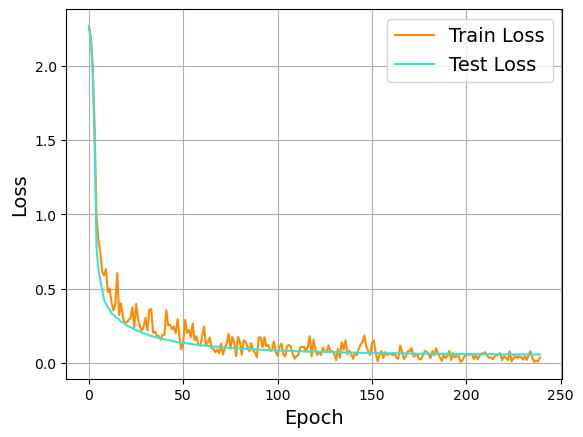

In [11]:
plot_loss(train_loss_list, test_loss_list)

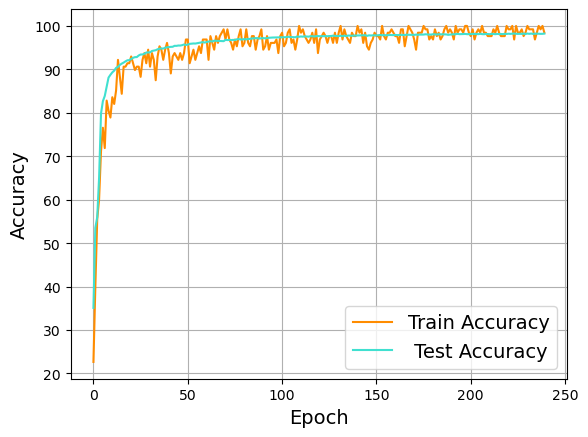

In [12]:
plot_acc(train_acc_list, test_acc_list)

# 6. 模型预测

In [16]:
# 导入模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))

<All keys matched successfully>

In [17]:
# 预处理方式
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),                           
    transforms.Normalize((0.1307,), (0.3081,))    
])

# 从 json 文件读取类别标签
with open("./class_indices.json", "r") as f:
    class_indices = json.load(f)

class_indices = {v: k for k, v in class_indices.items()}
print(class_indices)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


In [20]:
# 读取图片
img = Image.open('./images/0.png').convert('L')    
img = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(img.to(device))
    _, predicted = torch.max(output, 1) 
    pred_prob = torch.softmax(output, dim=1).tolist()[0]
    pred_prob = [round(i, 4) for i in pred_prob]         

print(f"预测概率: {pred_prob}")
print(f"预测结果: {class_indices[predicted.item()]}")

预测概率: [0.9937, 0.0001, 0.0004, 0.0, 0.0001, 0.0002, 0.0002, 0.0053, 0.0, 0.0]
预测结果: 0 - zero


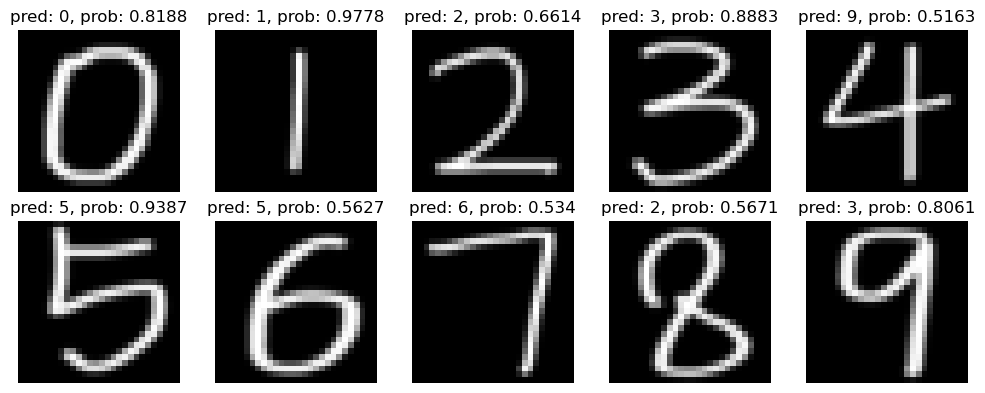

In [18]:
"""以上为单张图像预测 下面实现 10 张图像预测"""
plt.figure(figsize=(10, 4))

for i in range(10):
    img = Image.open(f'./images/{i}.png').convert('L')
    img = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img.to(device))
        _, predicted = torch.max(output, 1)
        pred_prob = torch.softmax(output, dim=1).tolist()[0]
        pred_prob = [round(i, 4) for i in pred_prob]    
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(f'pred: {predicted.item()}, prob: {pred_prob[predicted.item()]}')
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('result.png')
plt.show()